### Color Palette Demo

#### Libraries and Classes
Run the cells below to import all libraries and run all classes and functions

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from top_color import * 

In [4]:
class PaletteModel(nn.Module):
    def __init__(self, ni=15, no=15, hidden_seq=[64, 64, 32], lr=0.0001):
        super().__init__()
        self.ni = ni
        self.no = no
        self.hidden_seq = hidden_seq
        self.lr = lr
        self.hidden = self._get_hidden()
        self.out = HiddenBlock(self.hidden_seq[-1], self.no, activation=True, relu=False, dropout=False)
        self.loss = nn.L1Loss()
        #     self.loss = nn.MSELoss()
        self.optim = torch.optim.Adam(self.parameters(), lr=self.lr)

    def _get_hidden(self):
        hidden = []
        ni = self.ni
        for i in range(len(self.hidden_seq)):
            hidden.append(HiddenBlock(ni, self.hidden_seq[i], p=0.5))
            ni = self.hidden_seq[i]
    
        return nn.Sequential(*hidden)
  
    def forward(self, x):
        x = self.out(self.hidden(x))
        return x

#   def loss(self, y_pred, y_true):
#     y_pred = y_pred.reshape((-1, 5, 3))
#     y_true = y_true.reshape((-1, 5, 3))
#     return ((y_true - y_pred) ** 2).sum().sqrt()

#   def clipped_activation(self, x):
#     x[x < 0] = 1 + (x[x < 0] - (x[x < 0] // 1))
#     x[x > 1] = x[x > 1] - (x[x > 1] // 1)
#     return x

    def reset_lr(self, lr):
        for p in self.optim.param_groups:
            p['lr'] = lr

    def fit(self, x, y_true):
        self.optim.zero_grad()
        y_pred = self.forward(x)
        loss = self.loss(y_pred, y_true)
        loss.backward()
        self.optim.step()
        return y_pred, loss

In [5]:
class HiddenBlock(nn.Module):
    def __init__(self, ni, no, dropout=True, p=0.5, bias=True, relu=True, activation=True):
        super().__init__()
        lyr = nn.Linear(ni, no, bias)
        torch.nn.init.kaiming_normal_(lyr.weight)
        
        if bias: lyr.bias.data.zero_().add_(0.1)
        layers = [lyr]
        
        if activation:
            if relu: 
                layers += [nn.ReLU()]
            else:
                layers += [nn.Sigmoid()]

        if dropout: layers += [nn.Dropout(p)]

        self.seq = nn.Sequential(*layers)


    def forward(self, x):
        return self.seq(x)

In [6]:
model = torch.load('color_palette.pkl', map_location='cpu')

C:\Users\Brian.Ho\Anaconda3\envs\colorp3.5\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Brian.Ho\Anaconda3\envs\colorp3.5\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Brian.Ho\Anaconda3\envs\colorp3.5\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original

In [7]:
model

PaletteModel(
  (hidden): Sequential(
    (0): HiddenBlock(
      (seq): Sequential(
        (0): Linear(in_features=15, out_features=64, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
      )
    )
    (1): HiddenBlock(
      (seq): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
      )
    )
    (2): HiddenBlock(
      (seq): Sequential(
        (0): Linear(in_features=64, out_features=32, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
      )
    )
    (3): HiddenBlock(
      (seq): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
      )
    )
    (4): HiddenBlock(
      (seq): Sequential(
        (0): Linear(in_features=32, out_features=16, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (out): HiddenBlo

In [8]:
class AdobeDataset(Dataset):
    def __init__(self, fname='./adobe_color_palette.csv', train=True):
        self.df = pd.read_csv(fname)
        self.df = self.df[:10000] if train else self.df[10000:]
#         print(self.df.shape())
    def __len__(self):
        return self.df.shape[0]

    def _randomize(self, x):
        color_drop = np.random.randint(1, 3)
        drop_idx = np.random.randint(0, 4, size=color_drop)
        
        print(color_drop)
        print(drop_idx)
        
        for i in drop_idx:
            x[i*3] = -255
            x[i*3+1] = -255
            x[i*3+2] = -255

        return x

#     def _normalize(self, x):
#         return normalize(x, torch.Tensor(imagenet_stats[0]), torch.Tensor(imagenet_stats[1]))

#     def denormalize(self, x):
#         return denormalize(x, torch.Tensor(imagenet_stats[0]), torch.Tensor(imagenet_stats[1])).clamp(0, 1.0)

    def __getitem__(self, idx):
        print("idx :" ,idx)
        target = torch.Tensor(df.iloc[idx])
        input_color = self._randomize(target.clone())

        return {'target': target / 255, 'input_color': input_color / 255}

In [9]:
df = pd.read_csv("adobe_color_palette.csv")

In [10]:
def plt_all_images():
    val_ds = AdobeDataset(train=False)
    val_dl = DataLoader(val_ds, batch_size=1)
    
    val_batch = next(iter(val_dl)) #random pick
    print(val_batch)
    
    val_target, val_input = val_batch['target'], val_batch['input_color']
    val_res = model(val_input)
        
    print(" val_res.shape[0] {}".format(val_res.shape[0]))
    
    for i in range(val_res.shape[0]):
        print(i)
        # Input Image
        print('Input Palette')
        val_input_0 = np.array((val_input.cpu().data * 255).round()[i])
        c1 = [abs(int(i)) for i in val_input_0[0:3]]
        c2 = [abs(int(i)) for i in val_input_0[3:6]]
        c3 = [abs(int(i)) for i in val_input_0[6:9]]
        c4 = [abs(int(i)) for i in val_input_0[9:12]]
        c5 = [abs(int(i)) for i in val_input_0[12:15]]
        img_input = draw_img(c1, c2, c3, c4, c5).astype(np.uint8)
        plt.imshow(cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB))
        plt.show()

        # Output Image
        print('Output Palette')
        val_1 = np.array((val_res.cpu().data * 255).round()[i])
        c1 = [int(i) for i in val_1[0:3]]
        c2 = [int(i) for i in val_1[3:6]]
        c3 = [int(i) for i in val_1[6:9]]
        c4 = [int(i) for i in val_1[9:12]]
        c5 = [int(i) for i in val_1[12:15]]
        img_input = draw_img(c1, c2, c3, c4, c5).astype(np.uint8)
        plt.imshow(cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB))
        plt.show()

        # Merge Image
        print('Merged palette')
        val_merge = [j if j >= 0 else val_1[idx] for idx, j in enumerate(val_input_0)]
        c1 = [int(i) for i in val_merge[0:3]]
        c2 = [int(i) for i in val_merge[3:6]]
        c3 = [int(i) for i in val_merge[6:9]]
        c4 = [int(i) for i in val_merge[9:12]]
        c5 = [int(i) for i in val_merge[12:15]]
        img_input = draw_img(c1, c2, c3, c4, c5).astype(np.uint8)
        plt.imshow(cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB))
        plt.show()

        # Ground Truth
        print('Original Palette')
        val_target_0 = np.array((val_target.cpu().data * 255).round()[i])
        c1 = [int(i) for i in val_target_0[0:3]]
        c2 = [int(i) for i in val_target_0[3:6]]
        c3 = [int(i) for i in val_target_0[6:9]]
        c4 = [int(i) for i in val_target_0[9:12]]
        c5 = [int(i) for i in val_target_0[12:15]]
        img_input = draw_img(c1, c2, c3, c4, c5).astype(np.uint8)
        plt.imshow(cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB))
        plt.show()
        print('---------------------------------------------------------------------------------')
#         if i == 1: break

In [11]:
def draw_img(c1, c2, c3, c4, c5):
    blank_img = np.zeros(shape=(100, 500, 3)) + 255
    cv2.rectangle(blank_img, (0,0), (100, 100), tuple(c1[::-1]), cv2.FILLED)
    cv2.rectangle(blank_img, (100,0), (200, 100), tuple(c2[::-1]), cv2.FILLED)
    cv2.rectangle(blank_img, (200,0), (300, 100), tuple(c3[::-1]), cv2.FILLED)
    cv2.rectangle(blank_img, (300,0), (400, 100), tuple(c4[::-1]), cv2.FILLED)
    cv2.rectangle(blank_img, (400,0), (500, 100), tuple(c5[::-1]), cv2.FILLED)
    return blank_img

In [12]:
def hex2rgb(hex_color):
    if len(hex_color) == 7: hex_color = hex_color[1:] 
    rgb_color = [int(hex_color[i:i+2], 16) for i in [0, 2, 4]]
    return tuple(rgb_color)

In [36]:
def plot_variant(ori_hex, var_dict):
    NAMES = ['Complementary', 'Tradic', 'Tetradic']
    for v in range(2, 5):
        var = 'var_{}'.format(v)
        color_var = var_dict[var]
        print(var)
        print(color_var)
        print('{} Color'.format(NAMES[len(color_var)-1]))
        
        rgb = [hex2rgb(o) for o in ori_hex]
        plt.imshow(cv2.cvtColor(draw_img(*rgb).astype(np.uint8), cv2.COLOR_BGR2RGB))
        plt.show()
        
        for color_set in color_var:
            rgb_set = [hex2rgb(c) for c in color_set]
            plt.imshow(cv2.cvtColor(draw_img(*rgb_set).astype(np.uint8), cv2.COLOR_BGR2RGB))  
            plt.show()

In [14]:
def random_drop_palette(hex_color):
    rgb_color = [hex2rgb(h) for h in hex_color]
    
    input_color = rgb_color.copy()
    n_drop = np.random.randint(low=2, high=5)
    idx = list(range(0, 5))
    np.random.shuffle(idx)
    for i in range(5-n_drop):   idx.pop()
    for i in idx:               input_color[i] = (255, 255, 255)

    input_tensor = torch.Tensor(np.array(input_color).flatten())[None] / 255
    output_tensor = (model.eval()(input_tensor) * 255).data[0]
    
    output_img = output_tensor.data.numpy().astype(np.uint8)
    output_color = [(int(output_img[i]), int(output_img[i+1]), int(output_img[i+2])) for i in [0,3,6,9,12]]
    
    merge = input_color.copy()
    for i in idx: merge[i] = output_color[i]
        
    print("Input")
    plt.imshow(cv2.cvtColor(draw_img(*input_color).astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.show()
    print("Output")
    plt.imshow(cv2.cvtColor(draw_img(*output_color).astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.show()
    print("Merged")
    plt.imshow(cv2.cvtColor(draw_img(*merge).astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.show()
    print("Ground Truth")
    plt.imshow(cv2.cvtColor(draw_img(*rgb_color).astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.show()

#### Color Palette Generation
The model is still in development and might not deliver the best results yet

In [15]:
val_ds = AdobeDataset(train=False)
val_dl = DataLoader(val_ds, batch_size=1)
len(val_ds)
print(val_dl)

In [16]:
val_batch = next(iter(val_dl))

idx : 0
1
[0]


In [17]:
val_target, val_input = val_batch['target'], val_batch['input_color']
print(val_target)
print(val_input)

tensor([[0.9490, 0.2196, 0.2784, 0.7490, 0.2235, 0.2706, 0.9490, 0.7333, 0.7490,
         0.2510, 0.0275, 0.0667, 0.9490, 0.5333, 0.5333]])
tensor([[-1.0000, -1.0000, -1.0000,  0.7490,  0.2235,  0.2706,  0.9490,  0.7333,
          0.7490,  0.2510,  0.0275,  0.0667,  0.9490,  0.5333,  0.5333]])


In [18]:
val_res = model(val_input)

idx : 0
1
[2]
{'input_color': tensor([[ 0.9490,  0.2196,  0.2784,  0.7490,  0.2235,  0.2706, -1.0000, -1.0000,
         -1.0000,  0.2510,  0.0275,  0.0667,  0.9490,  0.5333,  0.5333]]), 'target': tensor([[0.9490, 0.2196, 0.2784, 0.7490, 0.2235, 0.2706, 0.9490, 0.7333, 0.7490,
         0.2510, 0.0275, 0.0667, 0.9490, 0.5333, 0.5333]])}
 val_res.shape[0] 1
0
Input Palette


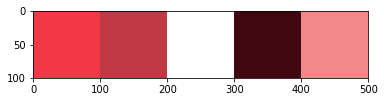

Output Palette


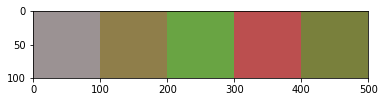

Merged palette


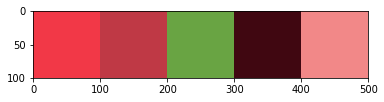

Original Palette


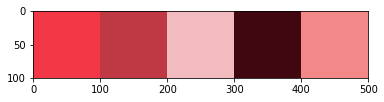

---------------------------------------------------------------------------------


In [19]:
plt.tight_layout()
plt_all_images()

#### Top (5) Color in Images
Retrieving top colors from images and generate complementary, triadic and tetradic colors from there

In [20]:
tck = TopColorKMeans(n_clusters=5)

In [21]:
img = cv2.imread('./demo.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

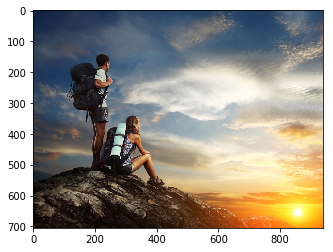

In [22]:
plt.imshow(img)

In [23]:
pct, hex_color, color_var = tck.get_top_color(img)

In [28]:
rgb = [hex2rgb(color) for color in hex_color]
print(rgb)

[(70, 83, 100), (224, 215, 190), (42, 29, 24), (141, 140, 136), (238, 169, 63)]


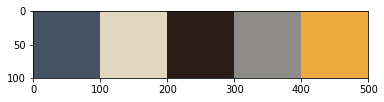

In [30]:
# Top Colors
plt.imshow(cv2.cvtColor(draw_img(*rgb).astype(np.uint8), cv2.COLOR_BGR2RGB))

var_2
[['#645746', '#bec7e0', '#18252a', '#88898d', '#3f84ee']]
Complementary Color


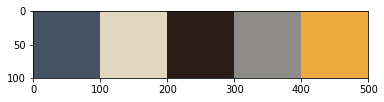

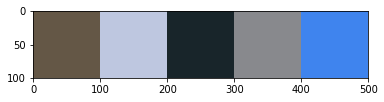

var_3
[['#644653', '#bee0d7', '#182a1d', '#888d8c', '#3feea9'], ['#536446', '#d7bee0', '#1d182a', '#8c888d', '#a93fee']]
Tradic Color


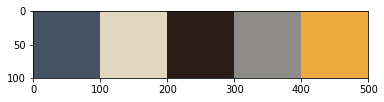

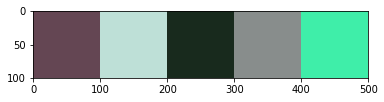

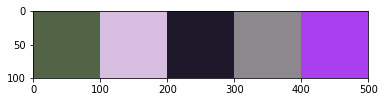

var_4
[['#644662', '#bee0c6', '#1c2a18', '#888d8a', '#3fee52'], ['#645746', '#bec7e0', '#18252a', '#88898d', '#3f84ee'], ['#466448', '#e0bed8', '#26182a', '#8d888c', '#ee3fdb']]
Tetradic Color


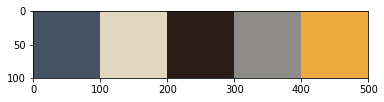

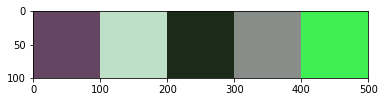

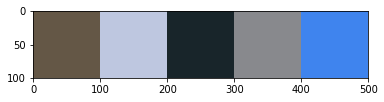

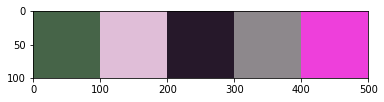

In [37]:
plot_variant(hex_color, color_var)

#### Randomly drop a few colors and try to regenerate the palette
White boxes in the input representing the dropped color.

Input


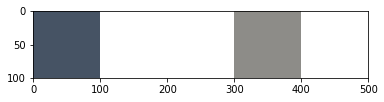

Output


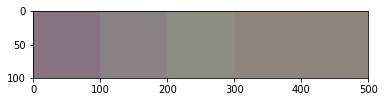

Merged


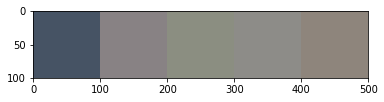

Ground Truth


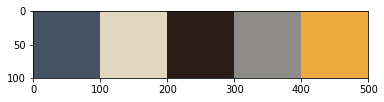

In [33]:
output_img = random_drop_palette(hex_color)
output_img